### Introduction to "Manifold Diffusion Geometry"

This notebook will take you through the main features of the paper https://arxiv.org/abs/2411.04100

This work builds on the programme of "diffusion geometry" introduced in https://arxiv.org/abs/2405.10858 and applies those methods to the special case of manifolds. Manifolds are special because they have a constant integer dimension, and tangent spaces, which we will compute explicitly here.

This notebook will follow the narrative of the paper and reproduce most of the results.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.datasets import make_swiss_roll
import skdim
import plotly.io as pio
pio.renderers.default = "png" ### This line is to make the plots show up in GitHub. Delete it for interactive 3d plots!!

from ManifoldDiffusionGeometry import *
from Visualise import *

### Sample some data
We'll use the "swiss roll" dataset in the scikit-dimension package.

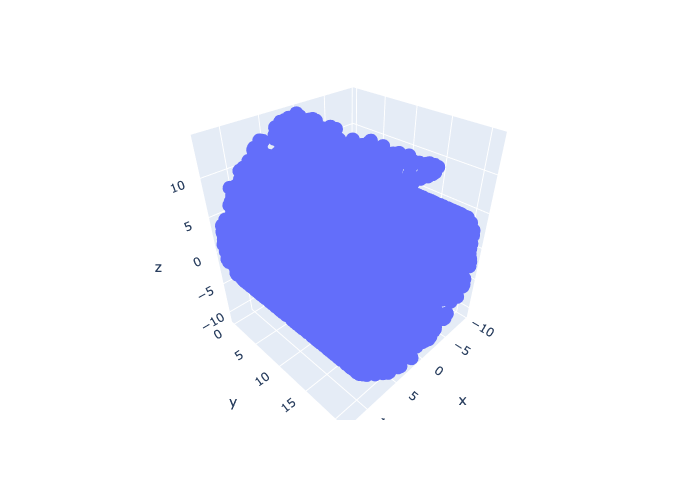

In [23]:
benchmark = skdim.datasets.BenchmarkManifolds(random_state=1)
data = benchmark.generate(n = 5000, noise = 0.)['M7_Roll']
px.scatter_3d(x = data[:,0],
              y = data[:,1],
              z = data[:,2]).show()

### First fundamental form: tangent spaces and dimension.

Diagonalising the first fundamental form will give estimates for the tangent spaces and dimension of the manifold. We will work up to computing the following data:

Global dimension: 2


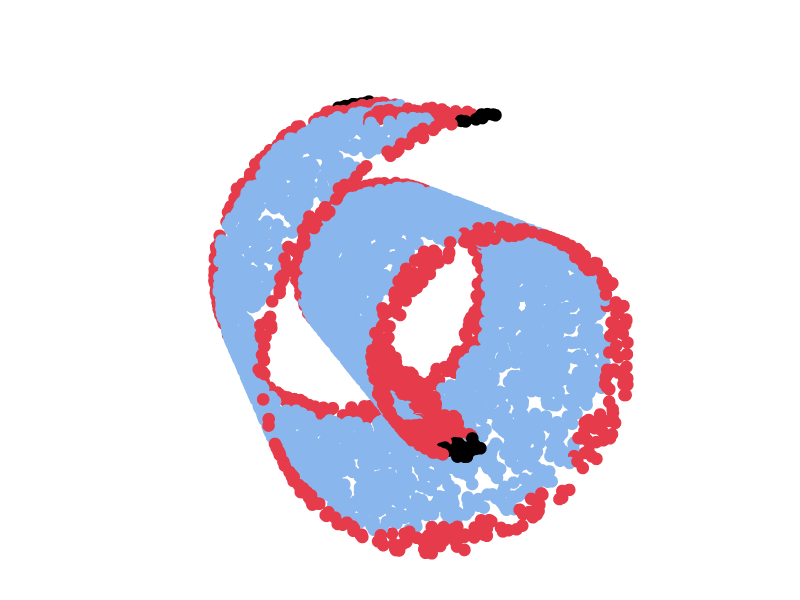

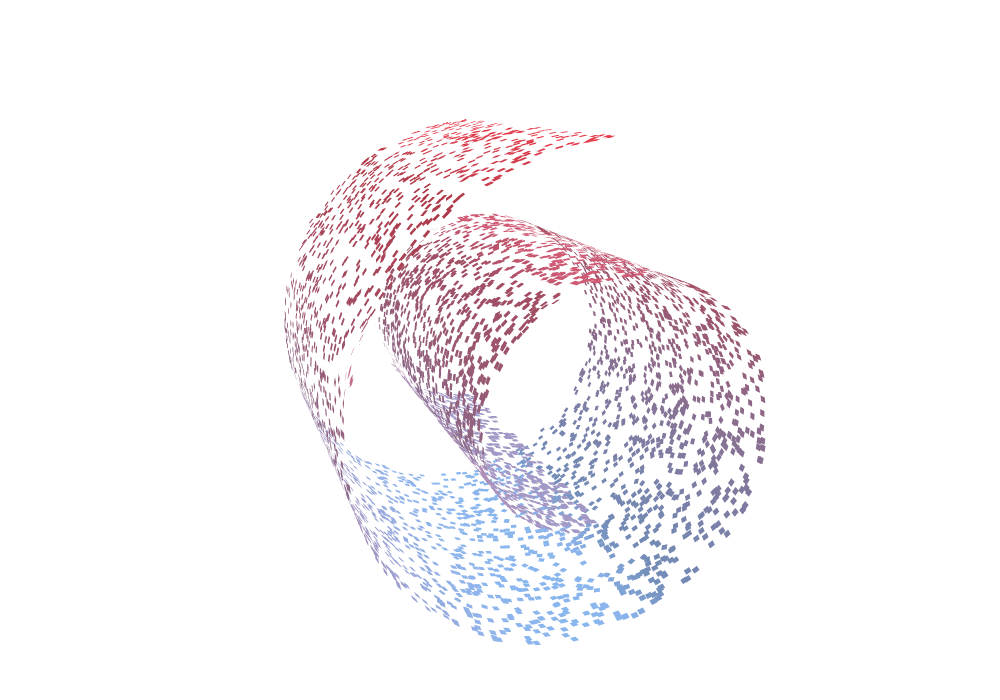

In [24]:
dim, pointwise_dimensions = Dimension_Estimate(data)
print('Global dimension:', dim)
fig1 = plot_dims_3d(data, pointwise_dimensions, [3,8,2], 0.12)
fig1.show()

bundle = Tangents(data)
fig2 = plot_tangent_planes_3d(bundle, data, [3,8,2], 0.12)
fig2.show()

The first thing we can compute with diffusion geometry is the first fundamental form. We start by computing the Laplacian with 'variable bandwidth diffusion maps'. We then use it to compute the Riemannian metric via the carré du champ formula
$$
g(\nabla f, \nabla h) = \frac{1}{2}\big(f\Delta(h) + h \Delta(f) - \Delta(fh) \big).
$$
We can apply the carré du champ to compute the matrix
$$
G(p) =
\begin{pmatrix}
g(\nabla_p x_1, \nabla_p x_1) & \dots & g(\nabla_p x_1, \nabla_p x_D) \\
\dots && \dots \\
g(\nabla_p x_D, \nabla_p x_1) & \dots & g(\nabla_p x_D, \nabla_p x_D) \\
\end{pmatrix}
=
\begin{pmatrix}
\Gamma(x_1,x_1) & \dots & \Gamma(x_1,x_D) \\
\dots && \dots \\
\Gamma(x_D,x_1) & \dots & \Gamma(x_D,x_D) \\
\end{pmatrix}
$$
where $x_i$, $i=1,...,D$ are the ambient coordinates. $G(p)$ will be $D \times D$ at every $p$ but only have rank $d$, the dimension of the manifold. 

In [25]:
tangent_bundle, pointwise_eigenvalues, L, G, _, _, _ = Tangents(data, return_all = True)

$L$ here is the Laplacian - the $n \times n$ matrix we get from diffusion maps:

In [26]:
L

<5000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 175314 stored elements in Compressed Sparse Row format>

$G$ is the first fundamental form matrix described above.

In [27]:
print(G.shape)

G[0]

(5000, 3, 3)


array([[ 0.10802852, -0.11959343, -0.19380027],
       [-0.11959343,  0.41607042,  0.21375267],
       [-0.19380027,  0.21375267,  0.35476941]])

The data tangent_bundle and pointwise_eigenvalues are the eigenvectors and eigenvalues of $G$. The eigenvalues measure local dimensionality.

(5000, 3, 3)
(5000, 3)


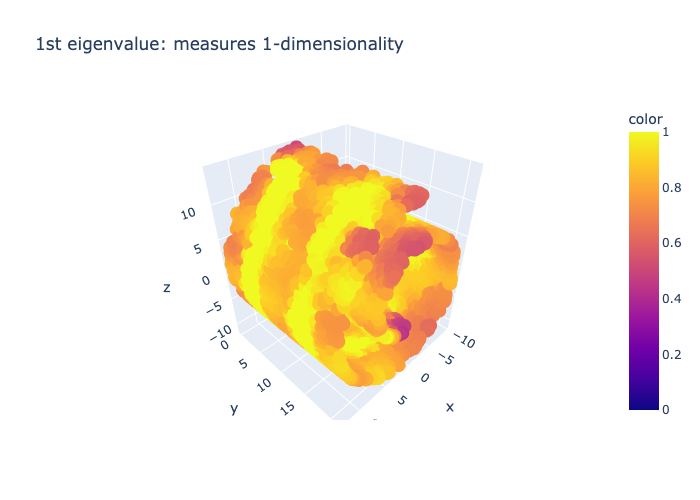

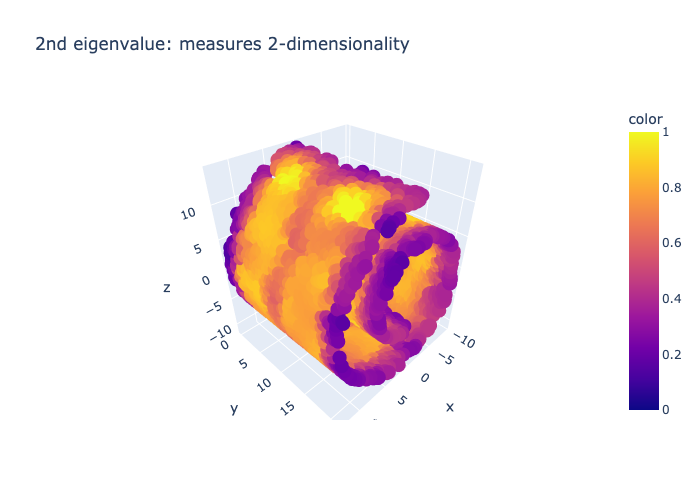

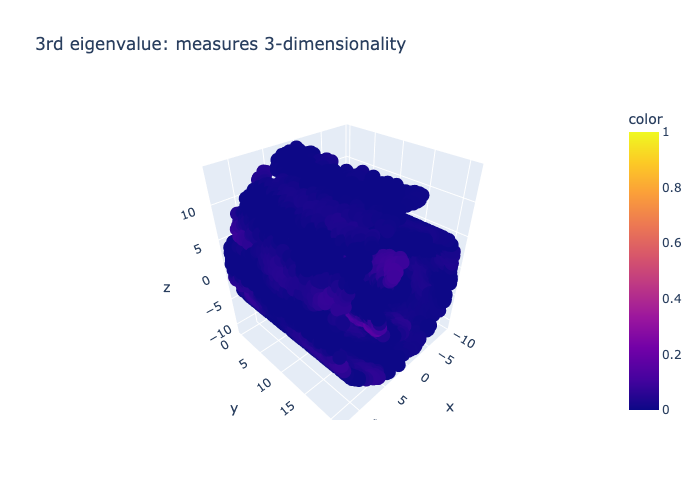

In [28]:
print(tangent_bundle.shape)
print(pointwise_eigenvalues.shape)

px.scatter_3d(x = data[:,0],
              y = data[:,1],
              z = data[:,2],
              color = pointwise_eigenvalues[:,0],
              range_color = [0,1],
              title = '1st eigenvalue: measures 1-dimensionality').show()
px.scatter_3d(x = data[:,0],
              y = data[:,1],
              z = data[:,2],
              color = pointwise_eigenvalues[:,1],
              range_color = [0,1],
              title = '2nd eigenvalue: measures 2-dimensionality').show()
px.scatter_3d(x = data[:,0],
              y = data[:,1],
              z = data[:,2],
              color = pointwise_eigenvalues[:,2],
              range_color = [0,1],
              title = '3rd eigenvalue: measures 3-dimensionality').show()

If the manifold is locally $d$-dimensional, the differences $\lambda_d - \lambda_{d+1}$ should be 1, and all the other differences should be zero.

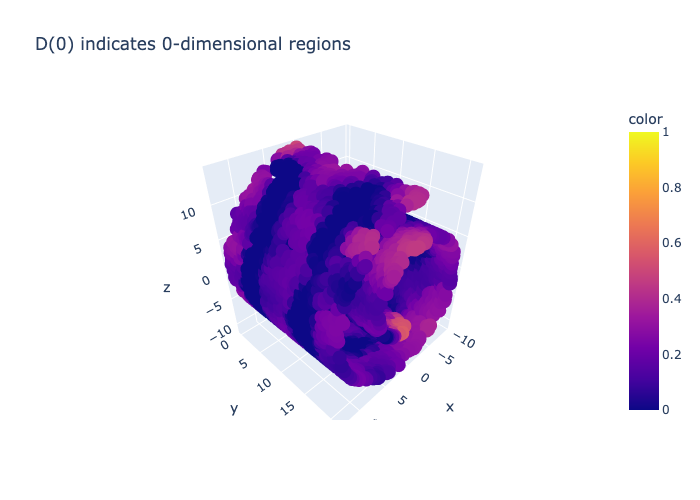

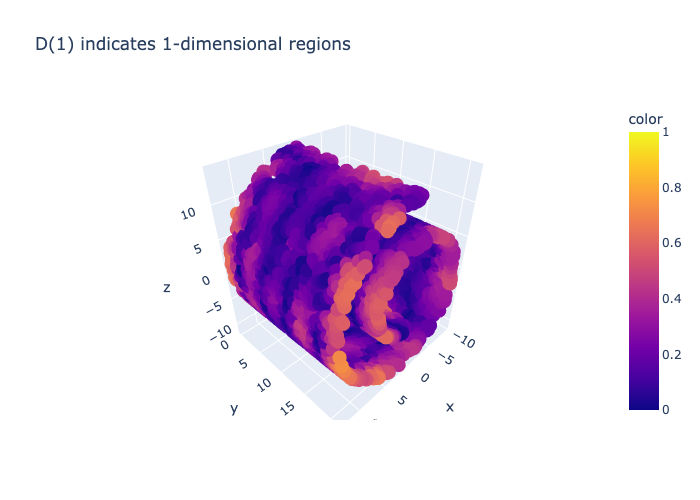

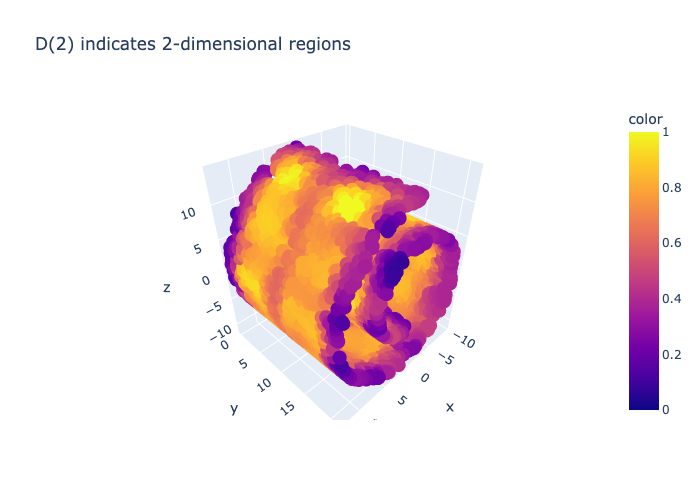

In [29]:
pointwise_differences = - np.diff(pointwise_eigenvalues, prepend=1, append=0)

px.scatter_3d(x = data[:,0],
              y = data[:,1],
              z = data[:,2],
              color = pointwise_differences[:,0],
              range_color = [0,1],
              title = 'D(0) indicates 0-dimensional regions').show()
px.scatter_3d(x = data[:,0],
              y = data[:,1],
              z = data[:,2],
              color = pointwise_differences[:,1],
              range_color = [0,1],
              title = 'D(1) indicates 1-dimensional regions').show()
px.scatter_3d(x = data[:,0],
              y = data[:,1],
              z = data[:,2],
              color = pointwise_differences[:,2],
              range_color = [0,1],
              title = 'D(2) indicates 2-dimensional regions').show()

Taking the argmax of the differences gives a local measure of dimension. In the proper function 'Dimension_Estimate' we apply an additional smoothing procedure which we will skip here.

Taking the median of this pointwise estimate gives a global estimate.

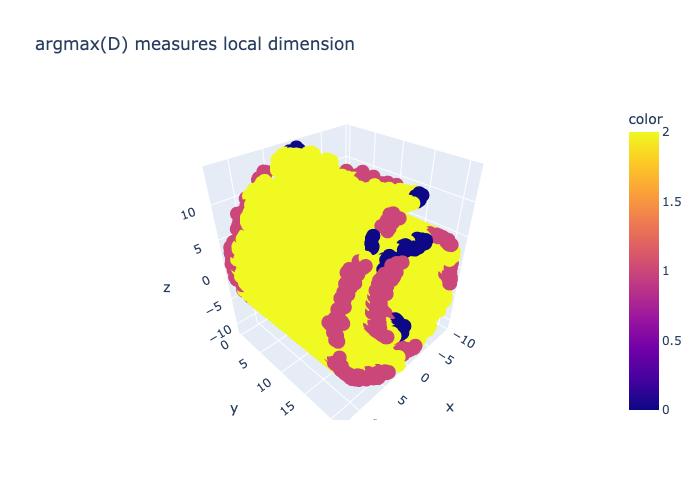

Global dimension: 2


In [30]:
pointwise_dimensions = np.argmax(pointwise_differences, axis=1)
px.scatter_3d(x = data[:,0],
              y = data[:,1],
              z = data[:,2],
              color = pointwise_dimensions,
              title = 'argmax(D) measures local dimension').show()

global_dimension = np.median(pointwise_dimensions).round()
print('Global dimension:', int(global_dimension))

This dimension estimate is very robust to noise and sparsity. We compare it to the two most robust other methods from our experiments: the correlation dimension and the method of moments.

The data is random, so try running this cell several times to observe the variance in the results.

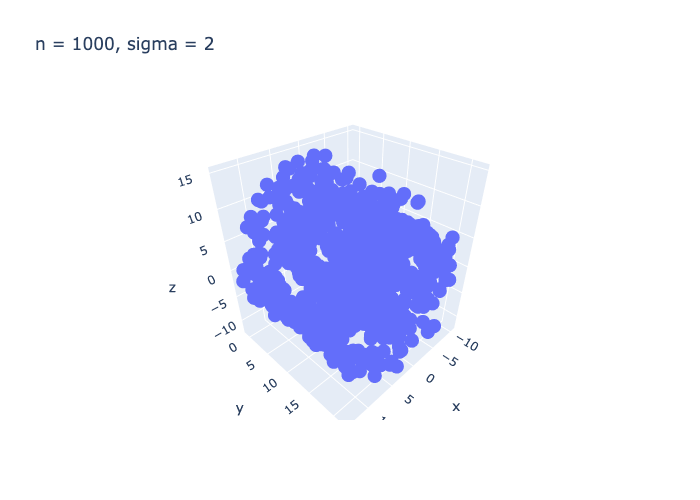

Diffusion geometry: 2
Correlation dimension: 2
Method of Moments: 2


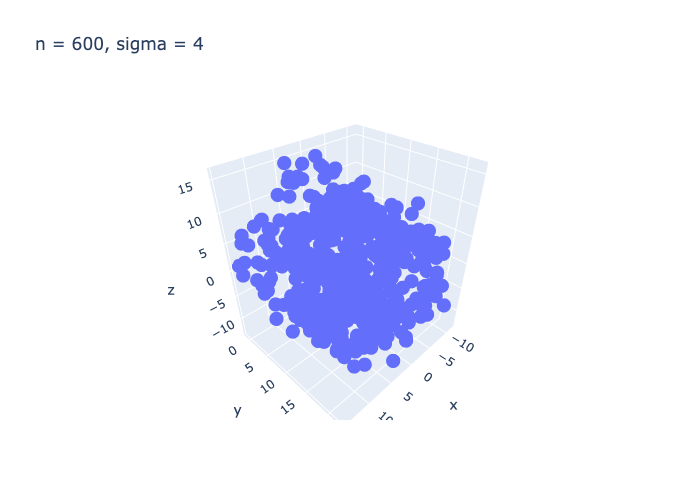

Diffusion geometry: 2
Correlation dimension: 2
Method of Moments: 3


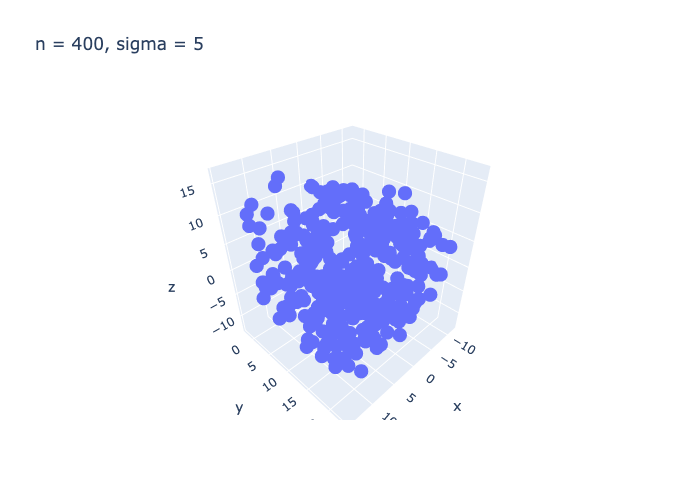

Diffusion geometry: 2
Correlation dimension: 3
Method of Moments: 2


In [31]:
data = benchmark.generate(n = 1000, noise = 2)['M7_Roll']
px.scatter_3d(x = data[:,0],
              y = data[:,1],
              z = data[:,2],
              title = 'n = 1000, sigma = 2').show()
print('Diffusion geometry:', Dimension_Estimate(data)[0])
print('Correlation dimension:', int(skdim.id.CorrInt().fit(data).dimension_.round()))
print('Method of Moments:', int(skdim.id.MOM().fit(data).dimension_.round()))

data = benchmark.generate(n = 600, noise = 4)['M7_Roll']
px.scatter_3d(x = data[:,0],
              y = data[:,1],
              z = data[:,2],
              title = 'n = 600, sigma = 4').show()
print('Diffusion geometry:', Dimension_Estimate(data)[0])
print('Correlation dimension:', int(skdim.id.CorrInt().fit(data).dimension_.round()))
print('Method of Moments:', int(skdim.id.MOM().fit(data).dimension_.round()))

data = benchmark.generate(n = 400, noise = 5)['M7_Roll']
px.scatter_3d(x = data[:,0],
              y = data[:,1],
              z = data[:,2],
              title = 'n = 400, sigma = 5').show()
print('Diffusion geometry:', Dimension_Estimate(data)[0])
print('Correlation dimension:', int(skdim.id.CorrInt().fit(data).dimension_.round()))
print('Method of Moments:', int(skdim.id.MOM().fit(data).dimension_.round()))

### Second fundamental form: curvature.

The curvature is a second order quantity, and can be expressed in terms of the Hessian (second derivative of functions). We can compute the Hessian from the Laplacian with the formula
$$
H(f)(\nabla h_1, \nabla h_2) = \frac{1}{2} \big( \Gamma(h_1, \Gamma(h_2, f)) + \Gamma(h_2, \Gamma(h_1, f)) - \Gamma(f, \Gamma(h_1, h_2)) \big)
$$
and use it in the Gauss equation to get the Riemann curvature $R_{ijkl}$.

From the Riemann curvature, we derive the Ricci
$$
\text{Ric}_{ij} = \sum_{k=1}^d R_{kikj}
$$
and scalar curvatures
$$
S = \sum_{i = 1}^d \text{Ric}_{ii} = \sum_{i,j = 1}^d R_{ijij}.
$$

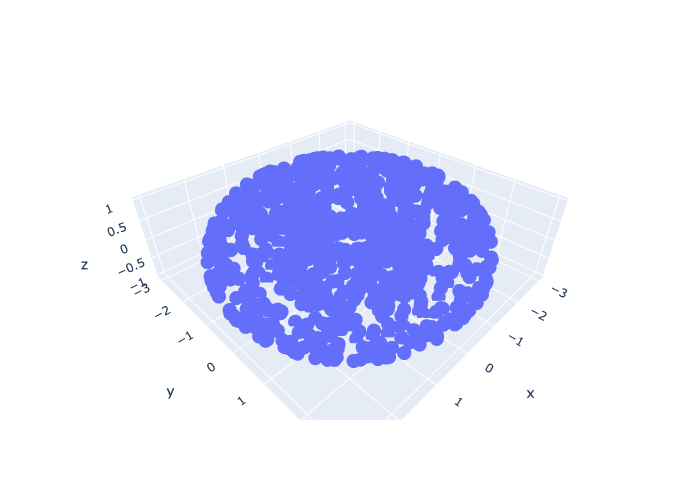

In [32]:
data = Torus(1, 2, 1000, 0.)
px.scatter_3d(x = data[:,0],
              y = data[:,1],
              z = data[:,2]).show()

tangent_bundle, Riemann, Ricci, scalar = Tangents_and_Curvature(data, d = 2)

The Riemann curvature is a 4-tensor.

In [33]:
print(Riemann.shape)

Riemann[0]

(1000, 2, 2, 2, 2)


array([[[[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],

        [[ 0.        ,  0.12532917],
         [-0.12532917,  0.        ]]],


       [[[ 0.        , -0.12532917],
         [ 0.12532917,  0.        ]],

        [[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]]]])

The Ricci curvature is a 2-tensor.

In [34]:
print(Ricci.shape)

Ricci[0]

(1000, 2, 2)


array([[0.12532917, 0.        ],
       [0.        , 0.12532917]])

The scalar curvature is a function (i.e. 0-tensor). We compare it to ground truth.

(1000,)
0.25065833944371035


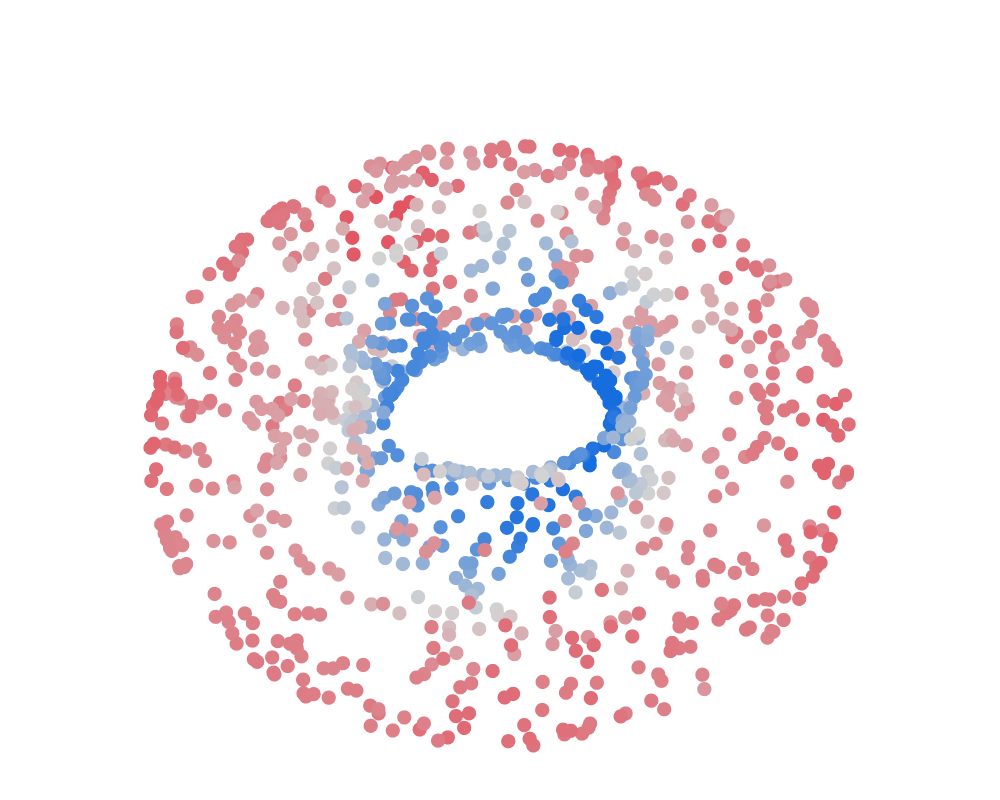

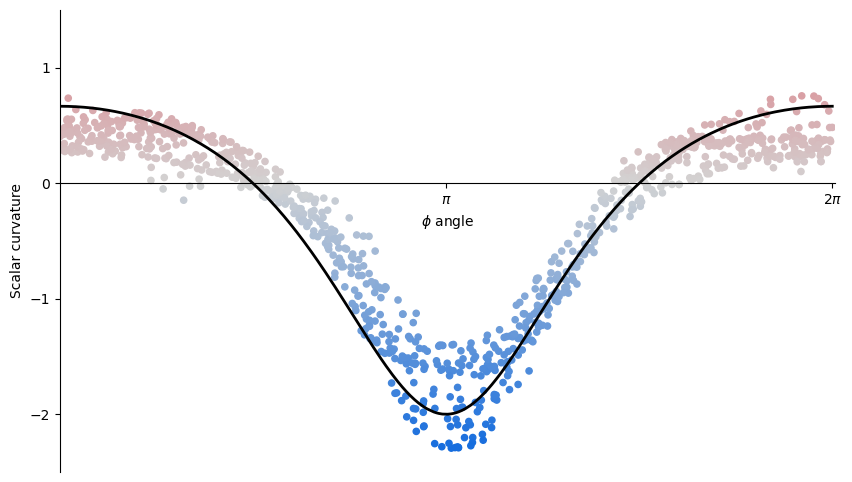

In [35]:
print(scalar.shape)
print(scalar[0])

plot_scalar_3d(data, scalar, range_col=[-2,1], angle = [3,3,4], zoom = 1.2).show()
plot_ground_truth_torus(1, 2, data, scalar)

As part of this curvature computation, we change the basis of the tangent spaces to the principal curvature directions, so the squares plotted should align with the curvature.

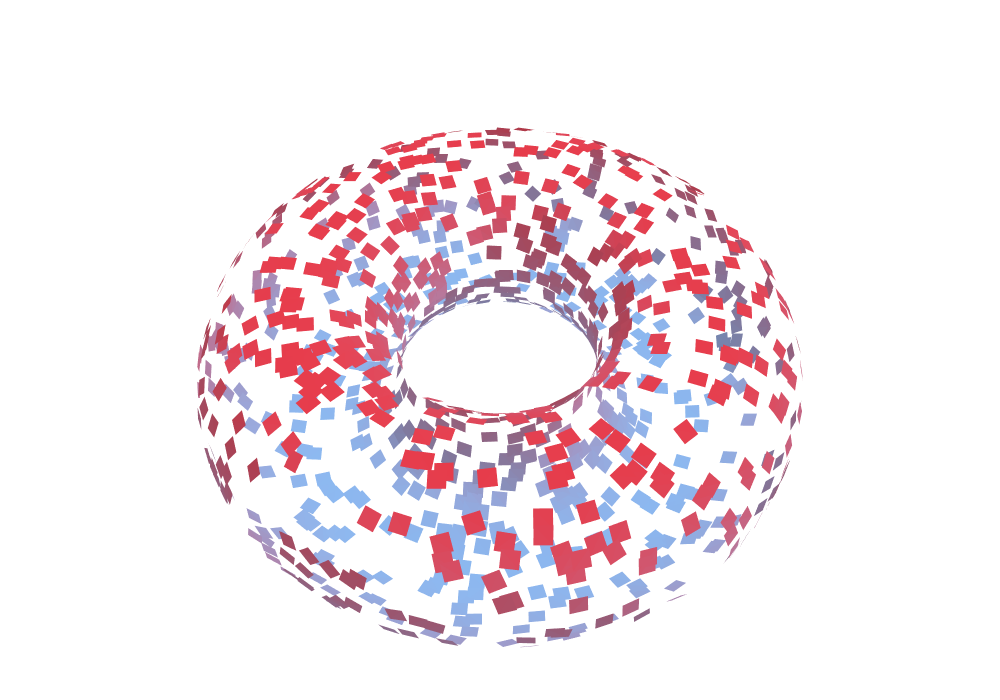

In [36]:
plot_tangent_planes_3d(tangent_bundle, data, angle = [3,3,4], zoom = 1.2).show()

Again, the most important issue here is robustness. Let's see how these curvature and tangent space estimates deal with noise and sparsity.

n = 1000, sigma = 0.1


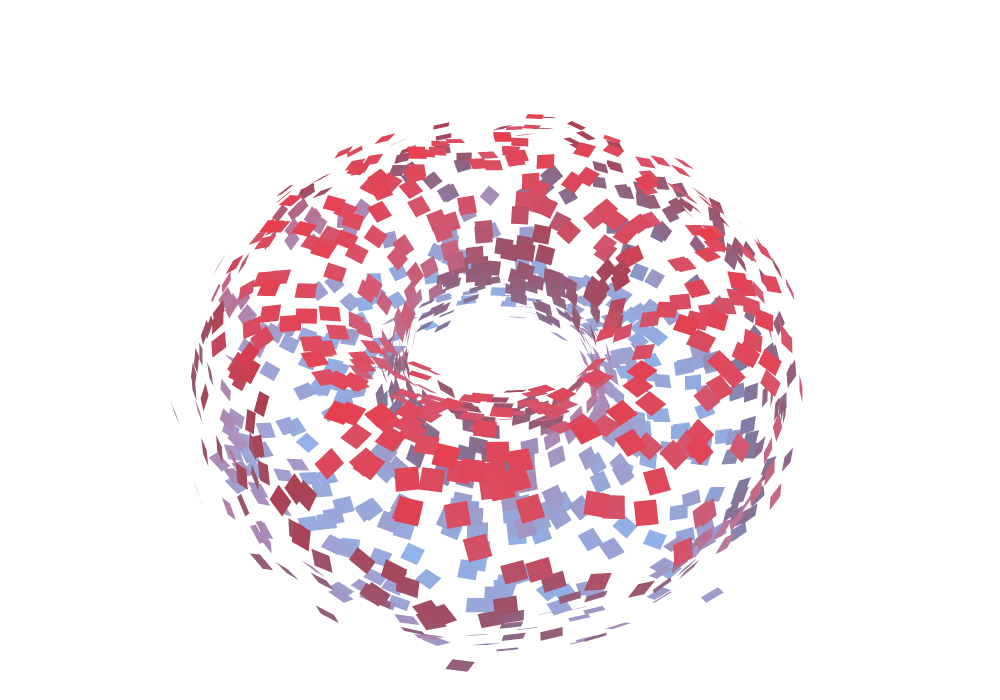

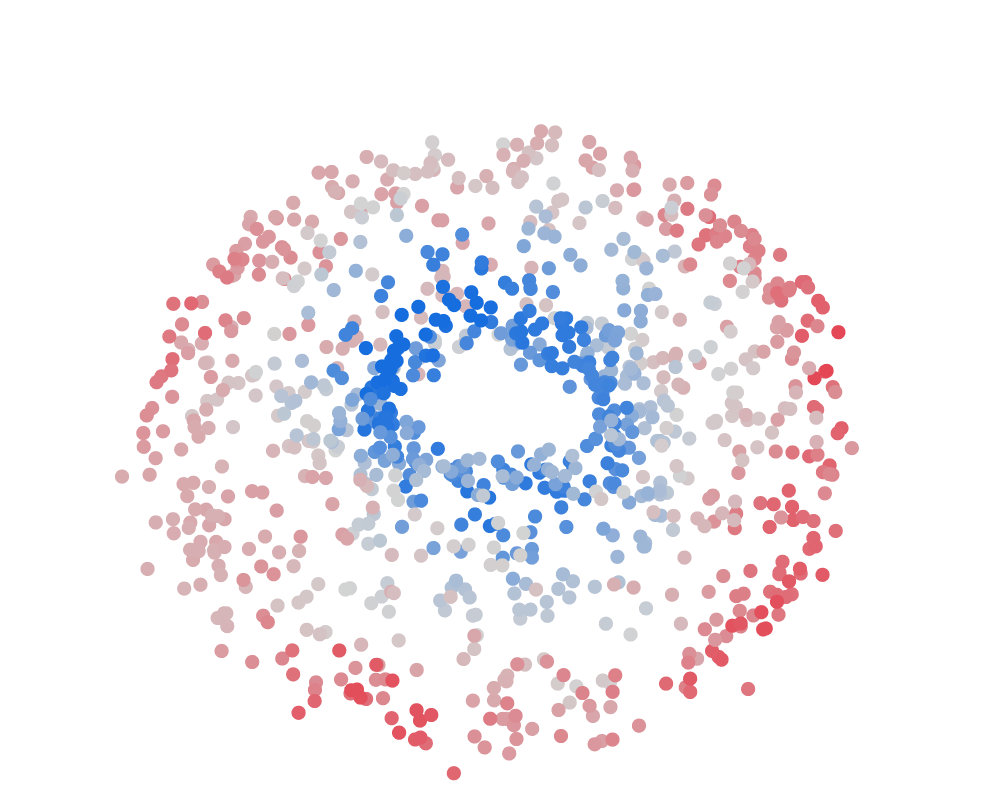

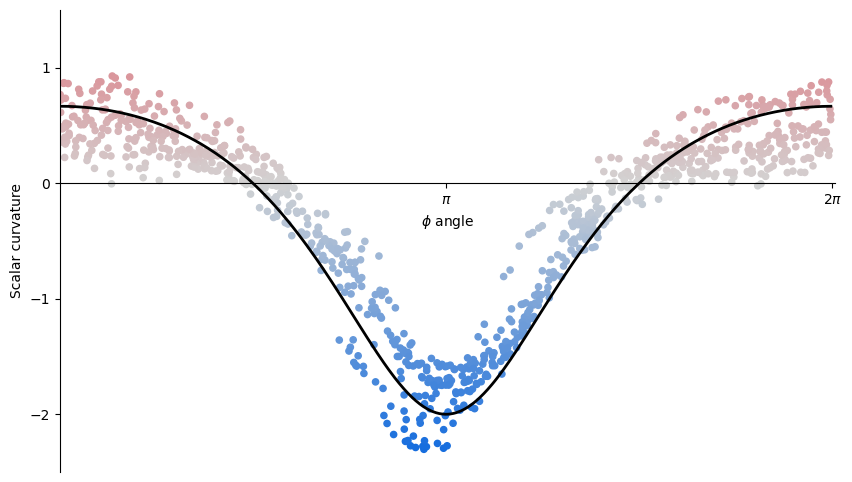

n = 600, sigma = 0.1


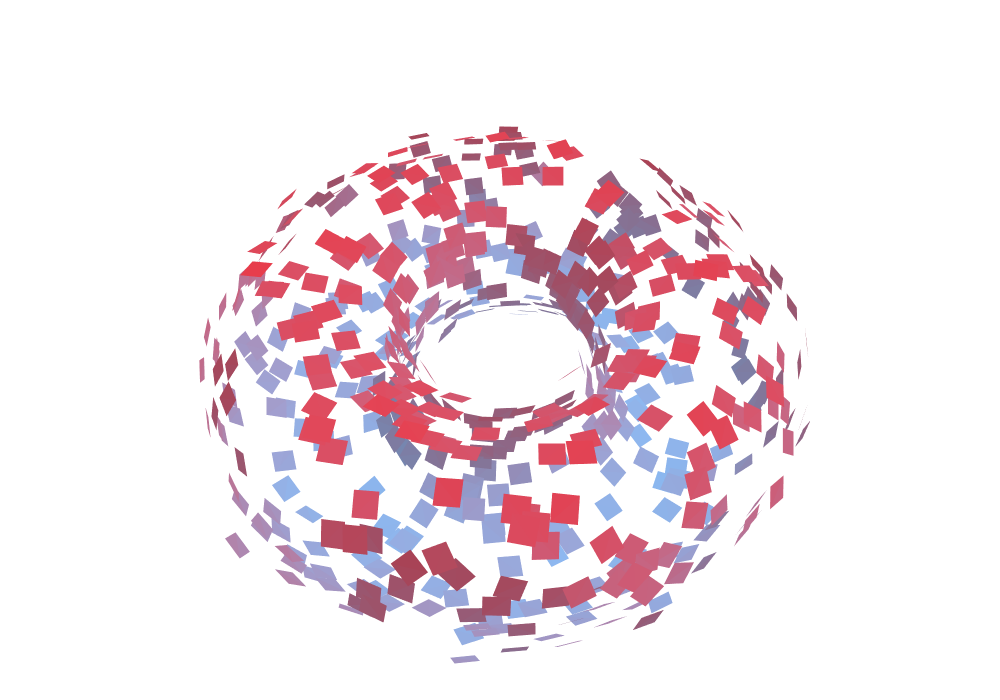

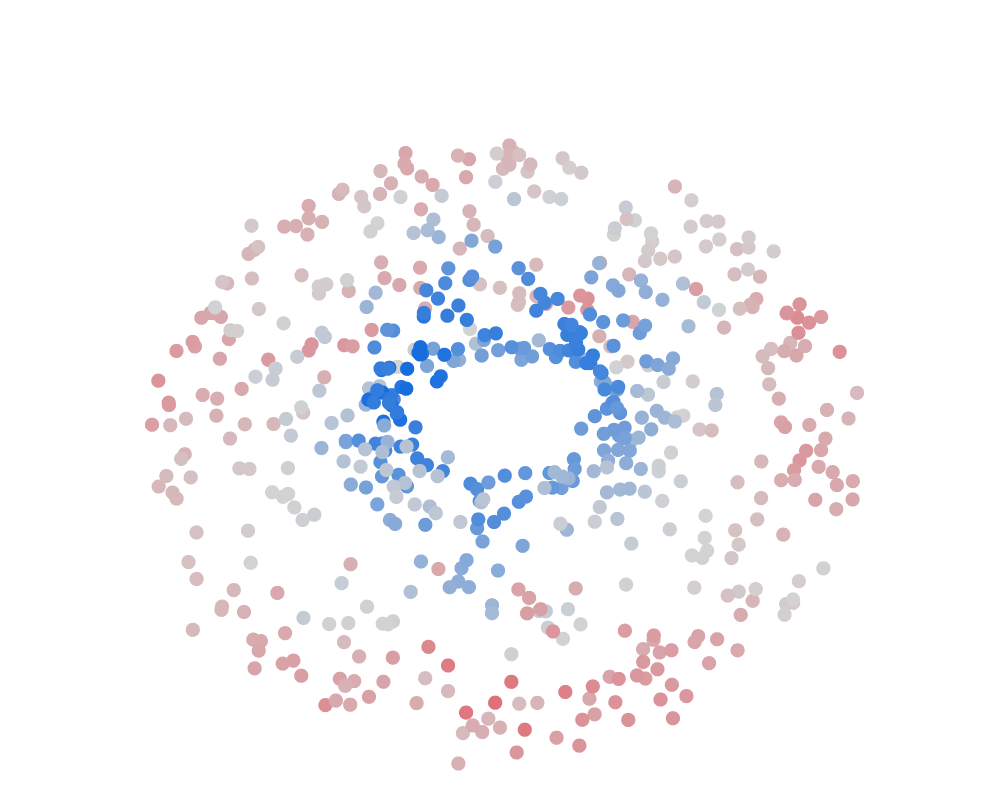

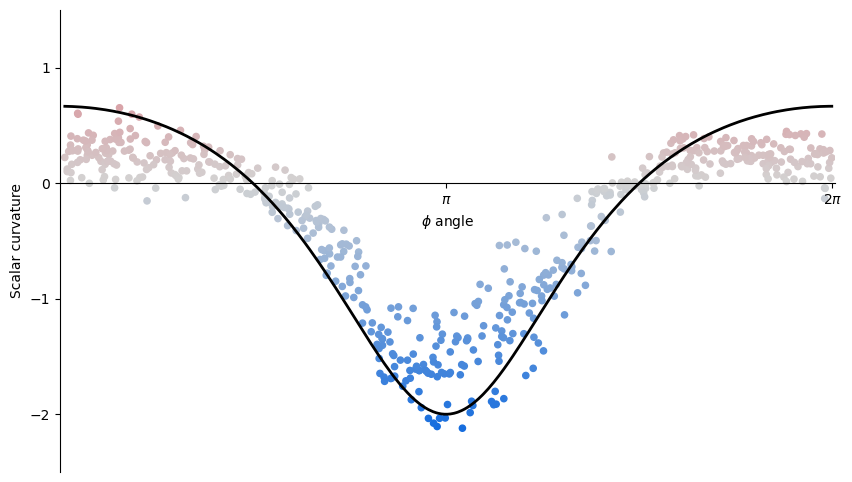

n = 500, sigma = 0.15


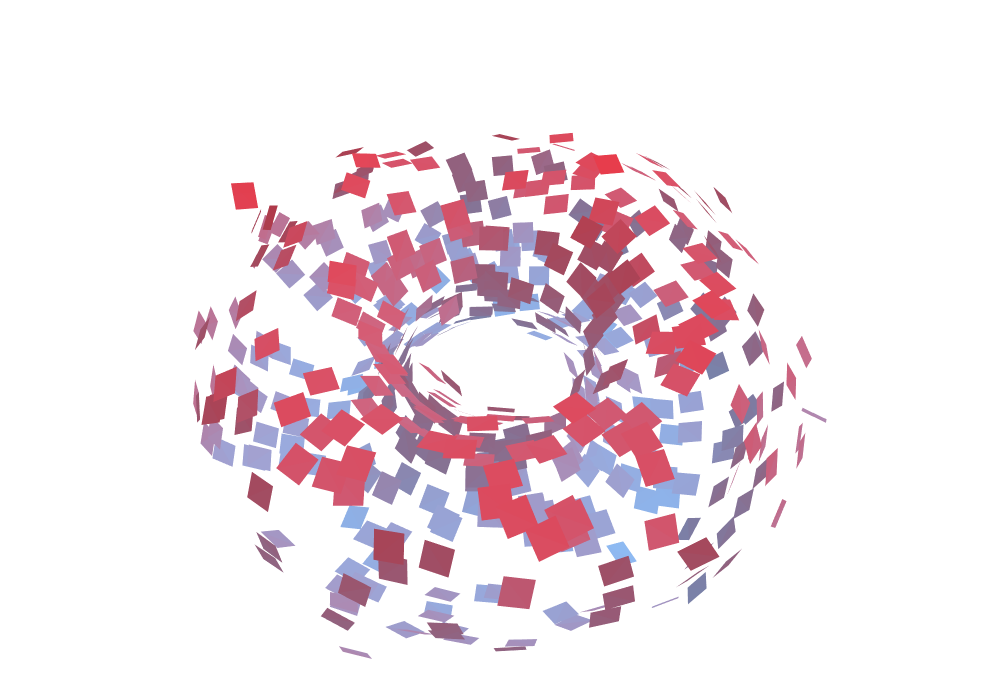

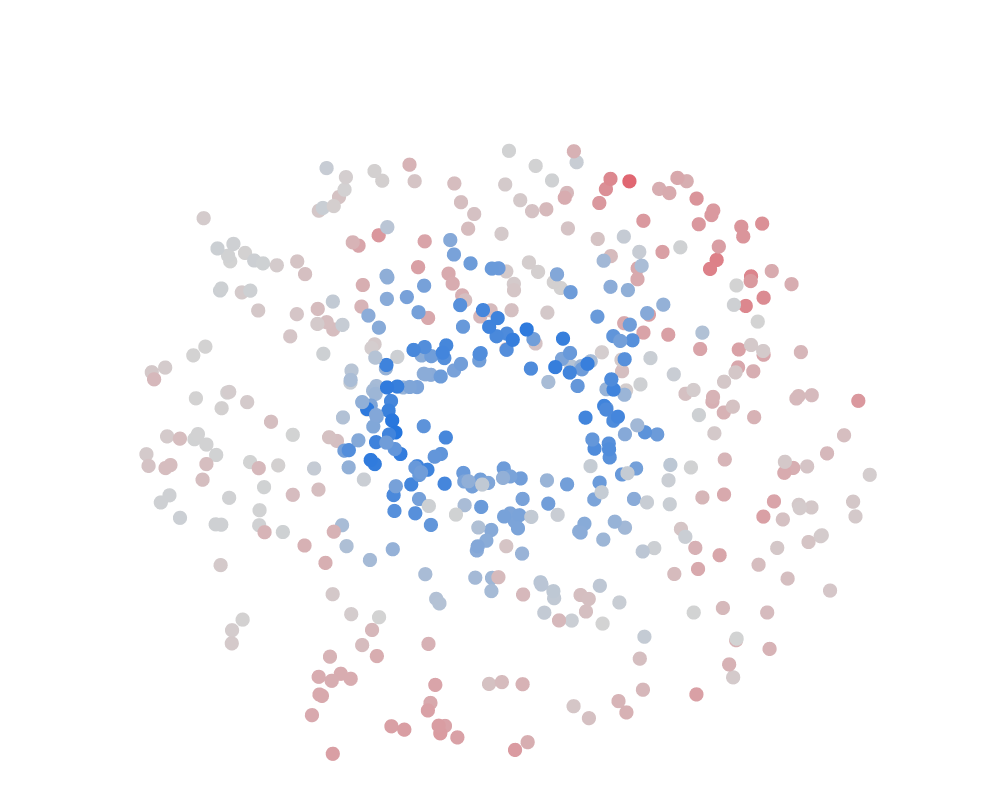

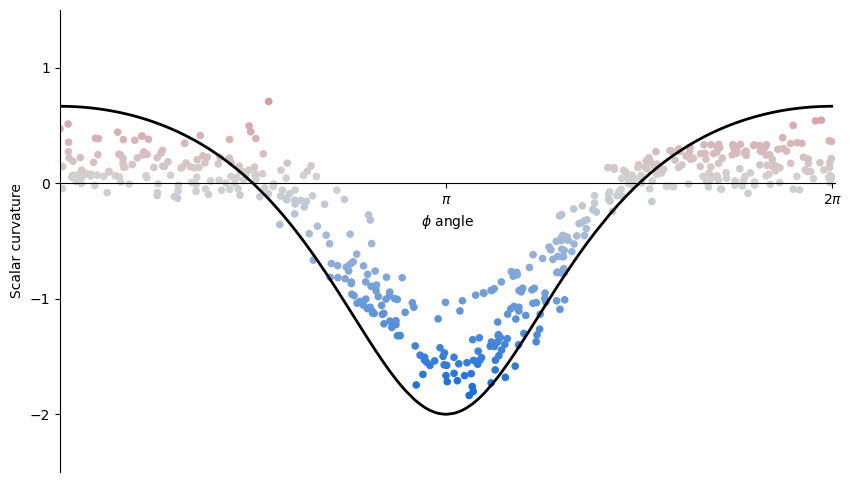

n = 250, sigma = 0


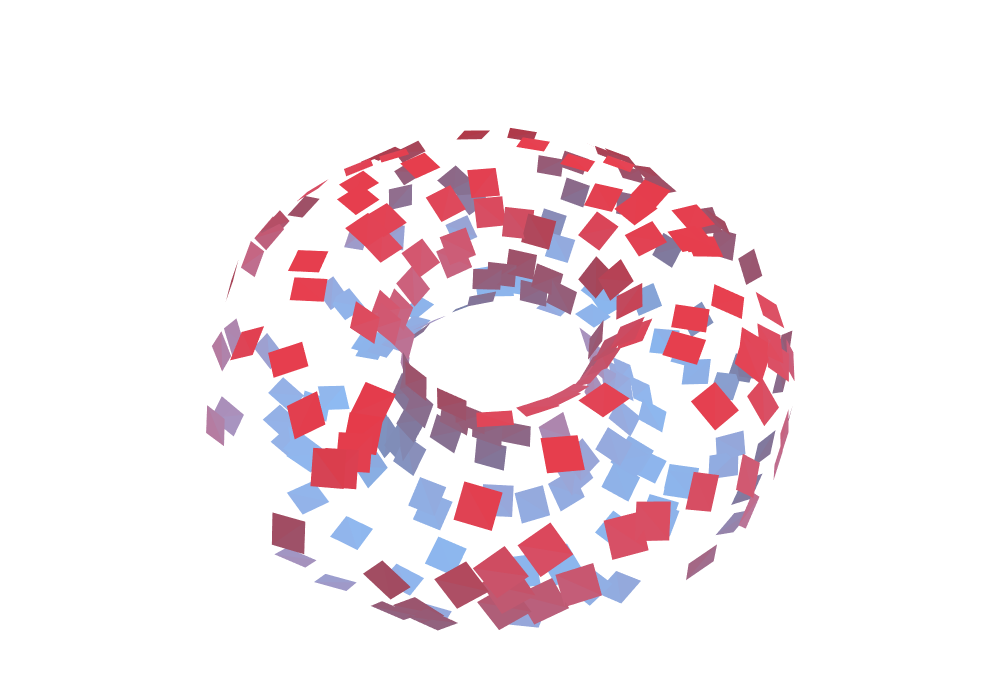

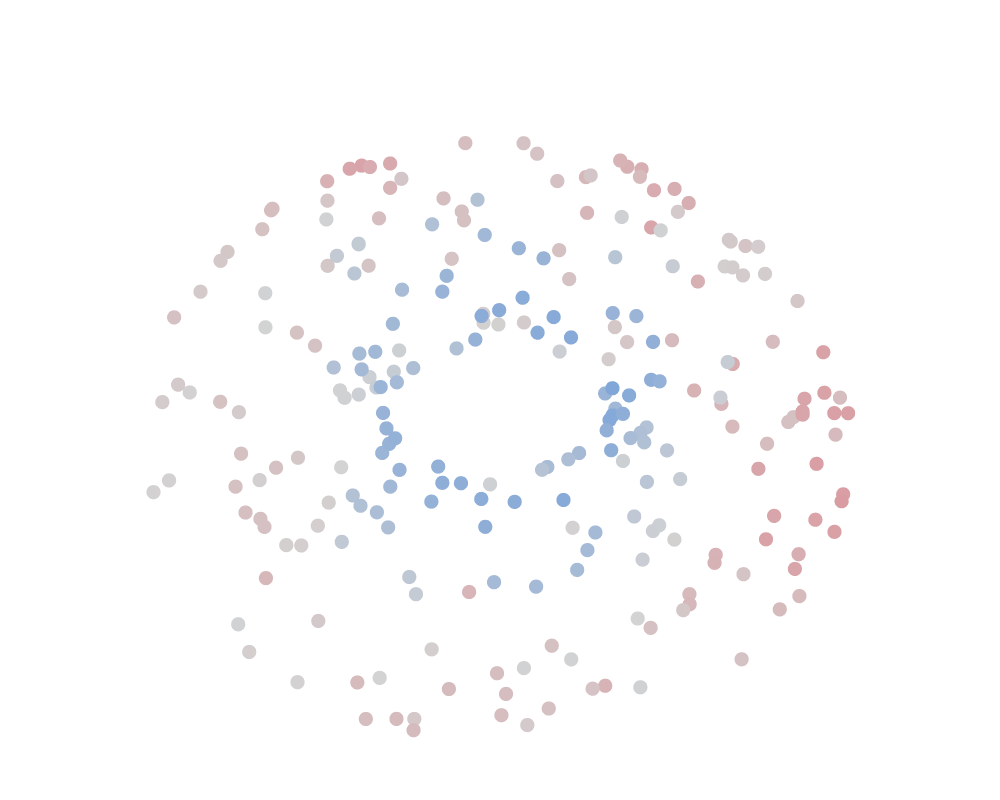

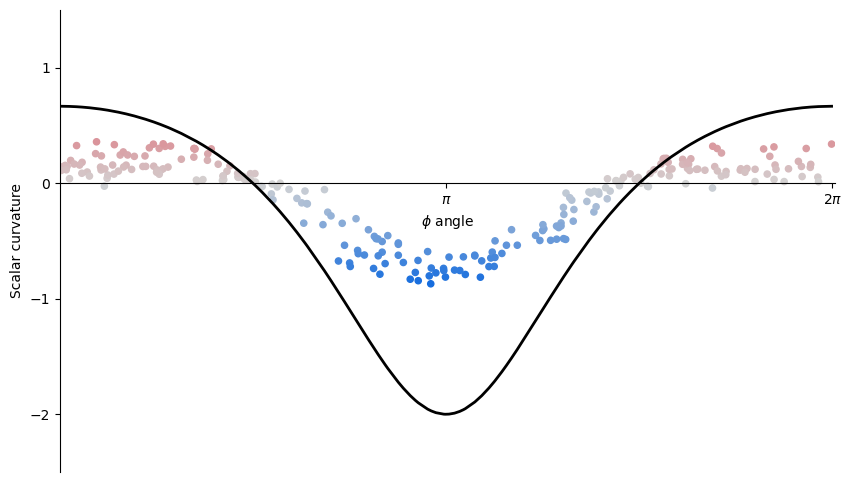

In [37]:
print('n = 1000, sigma = 0.1')
data = Torus(1, 2, 1000, 0.1)
tangent_bundle, _, _, scalar = Tangents_and_Curvature(data, d = 2)
plot_tangent_planes_3d(tangent_bundle, data, angle = [3,3,4], zoom = 1.2).show()
plot_scalar_3d_torus(data, scalar, angle = [3,3,4], zoom = 1.2).show()
plot_ground_truth_torus(1, 2, data, scalar)

print('n = 600, sigma = 0.1')
data = Torus(1, 2, 600, 0.1)
tangent_bundle, _, _, scalar = Tangents_and_Curvature(data, d = 2)
plot_tangent_planes_3d(tangent_bundle, data, angle = [3,3,4], zoom = 1.2).show()
plot_scalar_3d_torus(data, scalar, angle = [3,3,4], zoom = 1.2).show()
plot_ground_truth_torus(1, 2, data, scalar)

print('n = 500, sigma = 0.15')
data = Torus(1, 2, 500, 0.15)
tangent_bundle, _, _, scalar = Tangents_and_Curvature(data, d = 2)
plot_tangent_planes_3d(tangent_bundle, data, angle = [3,3,4], zoom = 1.2).show()
plot_scalar_3d_torus(data, scalar, angle = [3,3,4], zoom = 1.2).show()
plot_ground_truth_torus(1, 2, data, scalar)

print('n = 250, sigma = 0')
data = Torus(1, 2, 250, 0)
tangent_bundle, _, _, scalar = Tangents_and_Curvature(data, d = 2)
plot_tangent_planes_3d(tangent_bundle, data, angle = [3,3,4], zoom = 1.2).show()
plot_scalar_3d_torus(data, scalar, angle = [3,3,4], zoom = 1.2).show()
plot_ground_truth_torus(1, 2, data, scalar)